In [1]:
import numpy as np
from model_aug_shiftx import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt
import os

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
file_name = 'shiftx_NoAug_argminW_lr0.0002'
out_dir_path = '/data/scratch/jahanian/mnist_dcgantf_bkup/out_old'
checkpoint_dir = os.path.join(out_dir_path,file_name,'checkpoint' )
sample_dir = os.path.join(out_dir_path,file_name,'sample' )
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

loading mnist...
 [*] Reading checkpoints... /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/shiftx_NoAug_argminW_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/shiftx_NoAug_argminW_lr0.0002/checkpoint/model.b64-109000
 [*] Success to read model.b64-109000


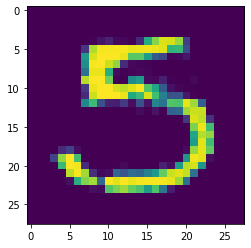

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/walk_train_aug/shiftx_l2_git{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 6)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
#             Loss_sum = Loss_sum + curr_loss
#             loss_values.append(curr_loss)

#             elapsed_time = time.time() - start_time

#             logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))
                
#             alpha_list.append(alpha_val)

#             if (optim_iter % 100 == 0) and (optim_iter > 0):
#                 saver.save(sess, './shift_l2_git/model_{}.ckpt'.format(optim_iter*batch_size), write_meta_graph=False, write_state=False)

#             optim_iter = optim_iter+1
            
#     if optim_iter > 0:
#         print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
#     saver.save(sess, "./shift_l2_git/model_{}_final.ckpt".format(optim_iter*batch_size), write_meta_graph=False, write_state=False)
#     return loss_values
            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-23 20:09:02,410 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.22754526138305664, 0, 0, 0.17772287130355835, 3
2019-09-23 20:09:02,419 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007906913757324219, 0, 10, 0.23152649402618408, -4
2019-09-23 20:09:02,428 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008368968963623047, 0, 20, 0.10051748156547546, 1
2019-09-23 20:09:02,439 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009027957916259766, 0, 30, 0.1882464736700058, -3
2019-09-23 20:09:02,449 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00905919075012207, 0, 40, 0.23649592697620392, 5
2019-09-23 20:09:02,459 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009652137756347656, 0, 50, 0.1653156280517578, -2
2019-09-23 20:09:02,471 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010179519653320312, 0, 60, 0.18189707398414612, -3
2019-09-23 20:09:02,482 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010179281234741211, 0, 70, 0.20603106915950775, -5
2019-09-23 20:09:02,492 [MainThr

2019-09-23 20:09:03,152 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009324073791503906, 0, 680, 0.14697743952274323, 3
2019-09-23 20:09:03,162 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009510993957519531, 0, 690, 0.13079337775707245, -5
2019-09-23 20:09:03,173 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009586572647094727, 0, 700, 0.0540345273911953, 1
2019-09-23 20:09:03,184 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009074211120605469, 0, 710, 0.05729282647371292, -1
2019-09-23 20:09:03,199 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014192342758178711, 0, 720, 0.10890369862318039, 2
2019-09-23 20:09:03,210 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00959634780883789, 0, 730, 0.186843603849411, 4
2019-09-23 20:09:03,222 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010431528091430664, 0, 740, 0.038249094039201736, 1
2019-09-23 20:09:03,239 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016108274459838867, 0, 750, 0.15292266011238098, -4
2019-09-23 20:09:03,251 

2019-09-23 20:09:03,886 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009465217590332031, 0, 1350, 0.02747482806444168, -1
2019-09-23 20:09:03,896 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008993148803710938, 0, 1360, 0.19891619682312012, 5
2019-09-23 20:09:03,907 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00939321517944336, 0, 1370, 0.14115837216377258, -5
2019-09-23 20:09:03,918 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00989985466003418, 0, 1380, 0.13614708185195923, 3
2019-09-23 20:09:03,929 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00975942611694336, 0, 1390, 0.16414105892181396, 4
2019-09-23 20:09:03,939 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009206533432006836, 0, 1400, 0.08614791184663773, 2
2019-09-23 20:09:03,949 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009463310241699219, 0, 1410, 0.06092507764697075, -2
2019-09-23 20:09:03,960 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008961915969848633, 0, 1420, 0.19787514209747314, 5
2019-09-23 20:09

2019-09-23 20:09:04,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017761945724487305, 0, 2020, 0.07178988307714462, 2
2019-09-23 20:09:04,659 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01277923583984375, 0, 2030, 0.11976804584264755, -3
2019-09-23 20:09:04,672 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01056218147277832, 0, 2040, 0.18636423349380493, -5
2019-09-23 20:09:04,683 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009934186935424805, 0, 2050, 0.09565766155719757, -3
2019-09-23 20:09:04,693 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009404659271240234, 0, 2060, 0.15900535881519318, 5
2019-09-23 20:09:04,704 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009260416030883789, 0, 2070, 0.15113717317581177, -5
2019-09-23 20:09:04,715 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009568929672241211, 0, 2080, 0.1559257209300995, 5
2019-09-23 20:09:04,725 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009500503540039062, 0, 2090, 0.17218995094299316, 5
2019-09-23 20:0

2019-09-23 20:09:05,372 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009070873260498047, 0, 2690, 0.030449634417891502, 1
2019-09-23 20:09:05,383 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010305643081665039, 0, 2700, 0.1359226256608963, -4
2019-09-23 20:09:05,395 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010162353515625, 0, 2710, 0.02934945374727249, 1
2019-09-23 20:09:05,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010007619857788086, 0, 2720, 0.15792103111743927, -5
2019-09-23 20:09:05,417 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009900093078613281, 0, 2730, 0.11040195822715759, -3
2019-09-23 20:09:05,428 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010027170181274414, 0, 2740, 0.16169747710227966, -5
2019-09-23 20:09:05,438 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009225130081176758, 0, 2750, 0.09603696316480637, 3
2019-09-23 20:09:05,448 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008930683135986328, 0, 2760, 0.15854743123054504, 5
2019-09-23 20:0

2019-09-23 20:09:06,076 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008958578109741211, 0, 3350, 0.034088294953107834, -1
2019-09-23 20:09:06,086 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009001731872558594, 0, 3360, 0.14742109179496765, -5
2019-09-23 20:09:06,096 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009204626083374023, 0, 3370, 0.07899587601423264, 2
2019-09-23 20:09:06,106 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009022951126098633, 0, 3380, 0.10667960345745087, 3
2019-09-23 20:09:06,118 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01016092300415039, 0, 3390, 0.14240163564682007, 5
2019-09-23 20:09:06,132 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013175725936889648, 0, 3400, 0.03174775466322899, 1
2019-09-23 20:09:06,145 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011482954025268555, 0, 3410, 0.10480678081512451, 3
2019-09-23 20:09:06,155 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009304523468017578, 0, 3420, 0.10388839244842529, -3
2019-09-23 20

2019-09-23 20:09:06,790 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009708166122436523, 0, 4010, 0.09916696697473526, 3
2019-09-23 20:09:06,800 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009321212768554688, 0, 4020, 0.07318273186683655, -2
2019-09-23 20:09:06,811 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009050369262695312, 0, 4030, 0.1467406004667282, -4
2019-09-23 20:09:06,821 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009368181228637695, 0, 4040, 0.03223823755979538, 1
2019-09-23 20:09:06,831 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008978605270385742, 0, 4050, 0.14103397727012634, -5
2019-09-23 20:09:06,842 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009612321853637695, 0, 4060, 0.026884563267230988, -1
2019-09-23 20:09:06,852 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009335517883300781, 0, 4070, 0.18942339718341827, 5
2019-09-23 20:09:06,863 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00938558578491211, 0, 4080, 0.06709502637386322, 2
2019-09-23 20

2019-09-23 20:09:07,473 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009119033813476562, 0, 4680, 0.11270412057638168, 4
2019-09-23 20:09:07,484 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010199785232543945, 0, 4690, 0.11054740846157074, -4
2019-09-23 20:09:07,494 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009062767028808594, 0, 4700, 0.10276351124048233, -3
2019-09-23 20:09:07,515 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008956670761108398, 0, 4710, 0.16809074580669403, 5
2019-09-23 20:09:07,525 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008707523345947266, 0, 4720, 0.1242617666721344, -4
2019-09-23 20:09:07,535 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009142637252807617, 0, 4730, 0.028740951791405678, 1
2019-09-23 20:09:07,546 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009779691696166992, 0, 4740, 0.060592953115701675, 2
2019-09-23 20:09:07,556 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008929729461669922, 0, 4750, 0.09318451583385468, 3
2019-09-23 2

2019-09-23 20:09:08,184 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008329629898071289, 0, 5340, 0.030227551236748695, -1
2019-09-23 20:09:08,192 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007028341293334961, 0, 5350, 0.05952541530132294, 2
2019-09-23 20:09:08,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008001327514648438, 0, 5360, 0.12382087111473083, 4
2019-09-23 20:09:08,213 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010594606399536133, 0, 5370, 0.13986186683177948, 5
2019-09-23 20:09:08,224 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009803533554077148, 0, 5380, 0.08865709602832794, 3
2019-09-23 20:09:08,238 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01295614242553711, 0, 5390, 0.0300300233066082, -1
2019-09-23 20:09:08,248 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009290218353271484, 0, 5400, 0.07218094915151596, 2
2019-09-23 20:09:08,259 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009333610534667969, 0, 5410, 0.07037573307752609, -2
2019-09-23 20:

Loss: [0.014084380242973565, 0.011143593780696391, 0.010205463482066988, 0.010366875985637307, 0.009244054263457657, 0.008807610945776105]
2019-09-23 20:09:08,901 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010174274444580078, 0, 6010, 0.10677184909582138, -3
2019-09-23 20:09:08,911 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00955057144165039, 0, 6020, 0.11633478850126266, 4
2019-09-23 20:09:08,922 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009876728057861328, 0, 6030, 0.03175133466720581, -1
2019-09-23 20:09:08,933 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009346723556518555, 0, 6040, 0.10020221769809723, 3
2019-09-23 20:09:08,945 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010696649551391602, 0, 6050, 0.06210271641612053, -2
2019-09-23 20:09:08,956 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00998544692993164, 0, 6060, 0.10796140879392624, 3
2019-09-23 20:09:08,966 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008966445922851562, 0, 6070, 0.06390843540430069, 2

2019-09-23 20:09:09,643 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009199380874633789, 0, 6670, 0.06781058013439178, 2
2019-09-23 20:09:09,654 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00987863540649414, 0, 6680, 0.11642216145992279, 4
2019-09-23 20:09:09,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010011672973632812, 0, 6690, 0.1138855367898941, -4
2019-09-23 20:09:09,675 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008851051330566406, 0, 6700, 0.13679563999176025, 4
2019-09-23 20:09:09,685 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008737564086914062, 0, 6710, 0.08737131953239441, -3
2019-09-23 20:09:09,698 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012139081954956055, 0, 6720, 0.11727889627218246, -4
2019-09-23 20:09:09,708 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008579015731811523, 0, 6730, 0.1357669234275818, 5
2019-09-23 20:09:09,716 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007859230041503906, 0, 6740, 0.0871921181678772, -3
2019-09-23 20:09

2019-09-23 20:09:10,407 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010305404663085938, 0, 7330, 0.09335808455944061, 3
2019-09-23 20:09:10,418 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009530782699584961, 0, 7340, 0.027140190824866295, -1
2019-09-23 20:09:10,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01021122932434082, 0, 7350, 0.15346769988536835, 5
2019-09-23 20:09:10,440 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00907588005065918, 0, 7360, 0.06759584695100784, -2
2019-09-23 20:09:10,450 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00913858413696289, 0, 7370, 0.11549645662307739, -4
2019-09-23 20:09:10,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010135889053344727, 0, 7380, 0.14865748584270477, -5
2019-09-23 20:09:10,471 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009150981903076172, 0, 7390, 0.030589040368795395, -1
2019-09-23 20:09:10,484 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011204242706298828, 0, 7400, 0.12855038046836853, -4
2019-09-23 

2019-09-23 20:09:11,148 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.023635387420654297, 0, 8000, 0.028894394636154175, 1
Loss: [0.014084380242973565, 0.011143593780696391, 0.010205463482066988, 0.010366875985637307, 0.009244054263457657, 0.008807610945776105, 0.00864644043892622, 0.009210370056331157]
2019-09-23 20:09:11,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010784387588500977, 0, 8010, 0.06846462190151215, -2
2019-09-23 20:09:11,172 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009641408920288086, 0, 8020, 0.12740135192871094, -5
2019-09-23 20:09:11,184 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010344982147216797, 0, 8030, 0.1106288805603981, -4
2019-09-23 20:09:11,197 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012382268905639648, 0, 8040, 0.1263381987810135, 4
2019-09-23 20:09:11,209 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010439395904541016, 0, 8050, 0.13419890403747559, 4
2019-09-23 20:09:11,219 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0089554

2019-09-23 20:09:11,870 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00889897346496582, 0, 8660, 0.13876184821128845, 5
2019-09-23 20:09:11,881 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009508371353149414, 0, 8670, 0.027453741058707237, 1
2019-09-23 20:09:11,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010361433029174805, 0, 8680, 0.13688799738883972, 5
2019-09-23 20:09:11,904 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010549068450927734, 0, 8690, 0.06488949805498123, -2
2019-09-23 20:09:11,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009617805480957031, 0, 8700, 0.09819823503494263, -3
2019-09-23 20:09:11,927 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010274648666381836, 0, 8710, 0.02742694318294525, 1
2019-09-23 20:09:11,939 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010725975036621094, 0, 8720, 0.030423739925026894, 1
2019-09-23 20:09:11,949 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00944828987121582, 0, 8730, 0.09627348929643631, 3
2019-09-23 20:

2019-09-23 20:09:12,568 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010046958923339844, 0, 9310, 0.025861084461212158, -1
2019-09-23 20:09:12,578 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00884699821472168, 0, 9320, 0.09287527203559875, -3
2019-09-23 20:09:12,588 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009020090103149414, 0, 9330, 0.0595853328704834, -2
2019-09-23 20:09:12,599 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009834527969360352, 0, 9340, 0.16421577334403992, -5
2019-09-23 20:09:12,618 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017563819885253906, 0, 9350, 0.11700870096683502, 4
2019-09-23 20:09:12,627 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008350133895874023, 0, 9360, 0.058392856270074844, -2
2019-09-23 20:09:12,638 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009190082550048828, 0, 9370, 0.032818473875522614, 1
2019-09-23 20:09:12,648 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009526491165161133, 0, 9380, 0.08824343979358673, 3
2019-09-23

2019-09-23 20:09:13,317 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009544610977172852, 0, 9980, 0.13532604277133942, 5
2019-09-23 20:09:13,328 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009914398193359375, 0, 9990, 0.08646674454212189, 3
2019-09-23 20:09:13,339 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010428428649902344, 0, 10000, 0.08820511400699615, 3
Loss: [0.014084380242973565, 0.011143593780696391, 0.010205463482066988, 0.010366875985637307, 0.009244054263457657, 0.008807610945776105, 0.00864644043892622, 0.009210370056331157, 0.008733669193461538, 0.008634007506072522]
2019-09-23 20:09:13,351 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010355234146118164, 0, 10010, 0.07464814186096191, -2
2019-09-23 20:09:13,363 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010478496551513672, 0, 10020, 0.05805589631199837, -2
2019-09-23 20:09:13,375 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010302543640136719, 0, 10030, 0.05887958034873009, -2
2019-09-23 20:09:13,385 [Main

2019-09-23 20:09:14,004 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009543180465698242, 0, 10630, 0.05655992776155472, 2
2019-09-23 20:09:14,014 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008852005004882812, 0, 10640, 0.11891721189022064, 4
2019-09-23 20:09:14,024 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009183168411254883, 0, 10650, 0.06059137359261513, 2
2019-09-23 20:09:14,033 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008242368698120117, 0, 10660, 0.1542876958847046, 5
2019-09-23 20:09:14,044 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009045839309692383, 0, 10670, 0.030178485438227654, 1
2019-09-23 20:09:14,054 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008925914764404297, 0, 10680, 0.14318470656871796, 5
2019-09-23 20:09:14,065 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010396003723144531, 0, 10690, 0.13985420763492584, 5
2019-09-23 20:09:14,076 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009890079498291016, 0, 10700, 0.11883201450109482, -4
2019-09

2019-09-23 20:09:14,720 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009986639022827148, 0, 11270, 0.12071862071752548, 4
2019-09-23 20:09:14,732 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010410785675048828, 0, 11280, 0.13083821535110474, 4
2019-09-23 20:09:14,747 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013695478439331055, 0, 11290, 0.027200914919376373, -1
2019-09-23 20:09:14,757 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009160041809082031, 0, 11300, 0.02698938548564911, 1
2019-09-23 20:09:14,770 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011458635330200195, 0, 11310, 0.10559800267219543, -3
2019-09-23 20:09:14,779 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00808572769165039, 0, 11320, 0.055449265986680984, -2
2019-09-23 20:09:14,789 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0088043212890625, 0, 11330, 0.16027677059173584, -5
2019-09-23 20:09:14,800 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009927511215209961, 0, 11340, 0.029240000993013382, 1
2019

2019-09-23 20:09:15,439 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009173154830932617, 0, 11930, 0.0611526183784008, 2
2019-09-23 20:09:15,450 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009720563888549805, 0, 11940, 0.030938705429434776, 1
2019-09-23 20:09:15,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009798526763916016, 0, 11950, 0.16519950330257416, -5
2019-09-23 20:09:15,471 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009519815444946289, 0, 11960, 0.026325136423110962, -1
2019-09-23 20:09:15,482 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009729623794555664, 0, 11970, 0.1483864039182663, -5
2019-09-23 20:09:15,493 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009732961654663086, 0, 11980, 0.08690642565488815, 3
2019-09-23 20:09:15,505 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010140180587768555, 0, 11990, 0.03007332980632782, -1
2019-09-23 20:09:15,513 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007187843322753906, 0, 12000, 0.12320024520158768, -4
Los

2019-09-23 20:09:16,134 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010532617568969727, 0, 12570, 0.0328080840408802, 1
2019-09-23 20:09:16,144 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009527206420898438, 0, 12580, 0.06364824622869492, -2
2019-09-23 20:09:16,155 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009356021881103516, 0, 12590, 0.13722234964370728, 5
2019-09-23 20:09:16,166 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009647130966186523, 0, 12600, 0.1226448267698288, -4
2019-09-23 20:09:16,177 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009042024612426758, 0, 12610, 0.07000938057899475, 2
2019-09-23 20:09:16,187 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009395837783813477, 0, 12620, 0.023571547120809555, -1
2019-09-23 20:09:16,198 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00939321517944336, 0, 12630, 0.03422672301530838, 1
2019-09-23 20:09:16,209 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00981450080871582, 0, 12640, 0.049938227981328964, -2
2019-0

2019-09-23 20:09:16,811 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009593009948730469, 0, 13210, 0.0574069507420063, -2
2019-09-23 20:09:16,821 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009299516677856445, 0, 13220, 0.06540019810199738, 2
2019-09-23 20:09:16,833 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011220455169677734, 0, 13230, 0.14085786044597626, 5
2019-09-23 20:09:16,844 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00933694839477539, 0, 13240, 0.1005023717880249, -3
2019-09-23 20:09:16,855 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009712934494018555, 0, 13250, 0.08504773676395416, -3
2019-09-23 20:09:16,866 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01031184196472168, 0, 13260, 0.14582546055316925, -5
2019-09-23 20:09:16,879 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011285781860351562, 0, 13270, 0.09040050208568573, -3
2019-09-23 20:09:16,890 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01023244857788086, 0, 13280, 0.023824354633688927, -1
2019-0

2019-09-23 20:09:17,557 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009653806686401367, 0, 13870, 0.11878727376461029, 5
2019-09-23 20:09:17,568 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009998798370361328, 0, 13880, 0.08976022899150848, 3
2019-09-23 20:09:17,579 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010025739669799805, 0, 13890, 0.05909166485071182, -2
2019-09-23 20:09:17,590 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010282754898071289, 0, 13900, 0.1271899938583374, -5
2019-09-23 20:09:17,601 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009578943252563477, 0, 13910, 0.06547647714614868, -2
2019-09-23 20:09:17,613 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010784149169921875, 0, 13920, 0.05463982746005058, 2
2019-09-23 20:09:17,624 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00942087173461914, 0, 13930, 0.11861445009708405, -4
2019-09-23 20:09:17,636 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010517597198486328, 0, 13940, 0.06639528274536133, -2
2019-

2019-09-23 20:09:18,282 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009073972702026367, 0, 14510, 0.09120204299688339, 3
2019-09-23 20:09:18,293 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010201454162597656, 0, 14520, 0.13277751207351685, 5
2019-09-23 20:09:18,304 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009822845458984375, 0, 14530, 0.1362842470407486, -5
2019-09-23 20:09:18,316 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010871171951293945, 0, 14540, 0.05987871438264847, 2
2019-09-23 20:09:18,326 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009182453155517578, 0, 14550, 0.026343951001763344, -1
2019-09-23 20:09:18,337 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009311676025390625, 0, 14560, 0.030279800295829773, -1
2019-09-23 20:09:18,348 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010277748107910156, 0, 14570, 0.1467205286026001, 5
2019-09-23 20:09:18,359 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009917497634887695, 0, 14580, 0.028967728838324547, 1
2019

2019-09-23 20:09:18,980 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008472442626953125, 0, 15150, 0.05159982666373253, -2
2019-09-23 20:09:18,991 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009552478790283203, 0, 15160, 0.1377190500497818, 5
2019-09-23 20:09:19,003 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010406732559204102, 0, 15170, 0.0556197315454483, 2
2019-09-23 20:09:19,014 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009674072265625, 0, 15180, 0.11656159162521362, -4
2019-09-23 20:09:19,024 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009053468704223633, 0, 15190, 0.1256314516067505, -5
2019-09-23 20:09:19,035 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009676694869995117, 0, 15200, 0.14256951212882996, 5
2019-09-23 20:09:19,047 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01083517074584961, 0, 15210, 0.11290417611598969, -4
2019-09-23 20:09:19,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009700298309326172, 0, 15220, 0.02977658435702324, 1
2019-09-23 

2019-09-23 20:09:19,706 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010856866836547852, 0, 15810, 0.1377934366464615, -5
2019-09-23 20:09:19,719 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01226496696472168, 0, 15820, 0.11873919516801834, 5
2019-09-23 20:09:19,732 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01107931137084961, 0, 15830, 0.07179001718759537, -3
2019-09-23 20:09:19,744 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010994911193847656, 0, 15840, 0.13071070611476898, 5
2019-09-23 20:09:19,755 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010289669036865234, 0, 15850, 0.02822355553507805, 1
2019-09-23 20:09:19,765 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00875091552734375, 0, 15860, 0.11186223477125168, -4
2019-09-23 20:09:19,777 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010164976119995117, 0, 15870, 0.026787500828504562, -1
2019-09-23 20:09:19,787 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009559392929077148, 0, 15880, 0.027963612228631973, 1
2019-0

2019-09-23 20:09:20,394 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009132623672485352, 0, 16440, 0.028871485963463783, 1
2019-09-23 20:09:20,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011157512664794922, 0, 16450, 0.13902269303798676, 5
2019-09-23 20:09:20,419 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011220932006835938, 0, 16460, 0.02414163202047348, -1
2019-09-23 20:09:20,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009847879409790039, 0, 16470, 0.10838108509778976, 3
2019-09-23 20:09:20,440 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008962631225585938, 0, 16480, 0.02707185037434101, 1
2019-09-23 20:09:20,451 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009704113006591797, 0, 16490, 0.1147492378950119, 4
2019-09-23 20:09:20,463 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011087894439697266, 0, 16500, 0.04799410700798035, -2
2019-09-23 20:09:20,476 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011155843734741211, 0, 16510, 0.01986752264201641, -1
2019-

2019-09-23 20:09:21,090 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010199785232543945, 0, 17070, 0.026167457923293114, -1
2019-09-23 20:09:21,101 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009738922119140625, 0, 17080, 0.1283198595046997, -5
2019-09-23 20:09:21,111 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00892186164855957, 0, 17090, 0.060729946941137314, -2
2019-09-23 20:09:21,121 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009116649627685547, 0, 17100, 0.10842477530241013, -4
2019-09-23 20:09:21,132 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009500265121459961, 0, 17110, 0.08452495187520981, 3
2019-09-23 20:09:21,143 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009395122528076172, 0, 17120, 0.02582346275448799, 1
2019-09-23 20:09:21,158 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013975143432617188, 0, 17130, 0.05684959143400192, -2
2019-09-23 20:09:21,168 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009327411651611328, 0, 17140, 0.12134011089801788, 5
201

2019-09-23 20:09:21,782 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009513616561889648, 0, 17730, 0.02778349444270134, 1
2019-09-23 20:09:21,793 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009793996810913086, 0, 17740, 0.11516373604536057, 4
2019-09-23 20:09:21,804 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009163379669189453, 0, 17750, 0.09014743566513062, -3
2019-09-23 20:09:21,815 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010316133499145508, 0, 17760, 0.12156903743743896, -4
2019-09-23 20:09:21,825 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008683919906616211, 0, 17770, 0.08385017514228821, 3
2019-09-23 20:09:21,835 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009008646011352539, 0, 17780, 0.10769002884626389, 4
2019-09-23 20:09:21,847 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010970115661621094, 0, 17790, 0.14053331315517426, -5
2019-09-23 20:09:21,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010064363479614258, 0, 17800, 0.025037189945578575, -1
201

2019-09-23 20:09:22,469 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008088111877441406, 0, 18360, 0.13572107255458832, -5
2019-09-23 20:09:22,477 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007858753204345703, 0, 18370, 0.10992160439491272, 5
2019-09-23 20:09:22,486 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007866859436035156, 0, 18380, 0.02715439349412918, 1
2019-09-23 20:09:22,497 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0093536376953125, 0, 18390, 0.021273821592330933, -1
2019-09-23 20:09:22,507 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00980830192565918, 0, 18400, 0.13475202023983002, 5
2019-09-23 20:09:22,515 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006877899169921875, 0, 18410, 0.05437205359339714, -2
2019-09-23 20:09:22,523 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00719761848449707, 0, 18420, 0.031174693256616592, 1
2019-09-23 20:09:22,531 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007233858108520508, 0, 18430, 0.02464544214308262, -1
2019-0

2019-09-23 20:09:23,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010145425796508789, 0, 19010, 0.023512467741966248, -1
2019-09-23 20:09:23,192 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009592533111572266, 0, 19020, 0.07972449064254761, 3
2019-09-23 20:09:23,203 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009751081466674805, 0, 19030, 0.1253872662782669, -5
2019-09-23 20:09:23,214 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009703874588012695, 0, 19040, 0.03178558498620987, 1
2019-09-23 20:09:23,225 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009528636932373047, 0, 19050, 0.03271074220538139, 1
2019-09-23 20:09:23,235 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009480953216552734, 0, 19060, 0.06684611737728119, -3
2019-09-23 20:09:23,246 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009701967239379883, 0, 19070, 0.06551523506641388, -2
2019-09-23 20:09:23,257 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009519338607788086, 0, 19080, 0.13366620242595673, -5
201

2019-09-23 20:09:23,898 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010000467300415039, 0, 19670, 0.052920639514923096, -2
2019-09-23 20:09:23,910 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010112524032592773, 0, 19680, 0.11506272852420807, 4
2019-09-23 20:09:23,921 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009730100631713867, 0, 19690, 0.06162174791097641, 2
2019-09-23 20:09:23,932 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009703874588012695, 0, 19700, 0.026661528274416924, -1
2019-09-23 20:09:23,943 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010332822799682617, 0, 19710, 0.13164067268371582, -5
2019-09-23 20:09:23,955 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010120153427124023, 0, 19720, 0.09292463213205338, 3
2019-09-23 20:09:23,965 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00964808464050293, 0, 19730, 0.05446664243936539, -2
2019-09-23 20:09:23,978 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011137247085571289, 0, 19740, 0.09227713197469711, -3
20

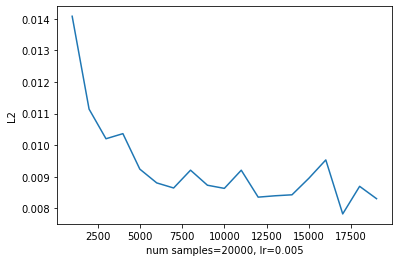

[0.014084380242973565, 0.011143593780696391, 0.010205463482066988, 0.010366875985637307, 0.009244054263457657, 0.008807610945776105, 0.00864644043892622, 0.009210370056331157, 0.008733669193461538, 0.008634007506072522, 0.009209296740591526, 0.008356428133323789, 0.00839952882193029, 0.008430657951161265, 0.008955063462257386, 0.009535171737894416, 0.007825408697128295, 0.00869888536632061, 0.008307727461680769]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/walk_train_aug/shiftx_l2_git0.005/output/model_20000.ckpt")

[-8 -6 -5 -4 -2  0  2  4  5  6  8]


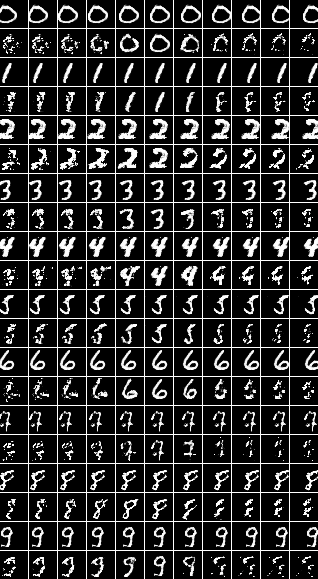

In [16]:
num_samples = 10
a = np.array([-8, -6, -5, -4, -2,  0,  2,  4,  5, 6,  8])

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Error'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -7.00, dist 0.02 +/- 0.01
alpha: -5.50, dist 0.01 +/- 0.00
alpha: -4.50, dist 0.02 +/- 0.01
alpha: -3.00, dist 0.06 +/- 0.02
alpha: -1.00, dist 0.07 +/- 0.03
alpha: 1.00, dist 0.07 +/- 0.03
alpha: 3.00, dist 0.06 +/- 0.02
alpha: 4.50, dist 0.01 +/- 0.01
alpha: 5.50, dist 0.01 +/- 0.00
alpha: 7.00, dist 0.01 +/- 0.01
2019-09-23 20:11:25,128 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-23 20:11:25,130 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


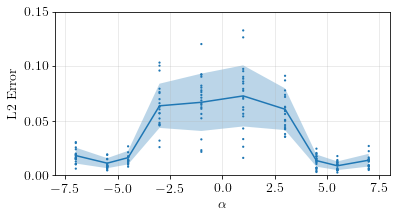

In [21]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/shiftx'
savefile_transform_effect = file_name+'_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_transform_effect + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_transform_effect + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -8.00, dist 0.19 +/- 0.01
alpha: -6.00, dist 0.16 +/- 0.01
alpha: -5.00, dist 0.13 +/- 0.01
alpha: -4.00, dist 0.11 +/- 0.01
alpha: -2.00, dist 0.06 +/- 0.01
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 2.00, dist 0.06 +/- 0.00
alpha: 4.00, dist 0.11 +/- 0.01
alpha: 5.00, dist 0.14 +/- 0.01
alpha: 6.00, dist 0.16 +/- 0.01
alpha: 8.00, dist 0.19 +/- 0.01


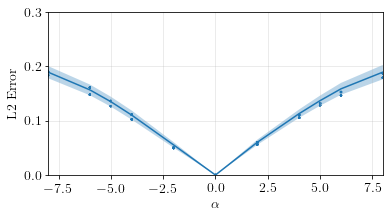

In [24]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/shiftx'
savefile_loss = file_name+'_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_loss + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_loss + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [25]:
np.save(os.path.join(output_dir, savefile_transform_effect+'.npy'), dist_info)
np.save(os.path.join(output_dir, savefile_loss+'.npy'), dist_trained_info)